# 2019 Inside Airbnb Data

## Packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

## Standardiser

In [2]:
mms  = MinMaxScaler(feature_range=(-1,1))
stds = StandardScaler()
rbs  = RobustScaler()
pts  = PowerTransformer()

## Customised Functions

### Plotting Function

In [3]:
# This is the plotting function Jon wrote

def plt_ldn(w, b):
    """
    Creates a new figure of a standard size with the 
    water (w) and boundary (b) layers set up for easy
    plotting. Right now this function assumes that you're
    looking at London, but you could parameterise it in
    other ways or allow it to work for other areas.
    
    w: a water layer for London
    b: a borough (or other) boundary layer for London
    """
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

########################
# These may no longer be relevant because of changes to geopandas API

def default_cmap(n, outliers=False):
    cmap = mpl.cm.get_cmap('viridis_r', n)
    colors = cmap(np.linspace(0,1,n))
    if outliers:
        gray = np.array([225/256, 225/256, 225/256, 1])
        colors = np.insert(colors, 0, gray, axis=0)
    return ListedColormap(colors)

# mappable = ax.collections[-1] if you add the geopandas
# plot last.
def add_colorbar(mappable, ax, cmap, norm, breaks, outliers=False):
    cb = fig.colorbar(mappable, ax=ax, cmap=cmap, norm=norm,
                    boundaries=breaks,
                    extend=('min' if outliers else 'neither'), 
                    spacing='uniform',
                    orientation='horizontal',
                    fraction=0.05, shrink=0.5, pad=0.05)
    cb.set_label("Cluster Number")

### Caching Function

In [4]:
import os
from requests import get
from urllib.parse import urlparse

# This is the cache function Jon wrote
def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    # os.path.getsize() gets the size of the file
    # if it doesn't exist, its size is less than 1
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

## Import Raw Airbnb Data and Convert Data types

This section will focus on cleaning raw airbnb data from 2019.

By the end of this section, we will get a new dataframe which only contains columns that we are interested in.

In [5]:
# read in 2019 airbnb raw data
airbnb_raw = pd.read_csv('London-2019-listings.csv.gz', compression='gzip', low_memory=False)
print(f"Data frame is {airbnb_raw.shape[0]:,} x {airbnb_raw.shape[1]}")

Data frame is 85,068 x 106


In [6]:
# Here I am parametrising the data by defining the columns so I can work with them more easily. 
# This comes from the FSDS practical 5.
cols = ['id', 'listing_url', 'last_scraped', 'name', 'description', 'host_id', 'host_name', 
        'host_since', 'host_location', 'host_about', 'host_is_superhost', 
        'host_listings_count', 'host_total_listings_count', 'host_verifications', 'latitude', 'longitude', 
        'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 
        'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 
        'first_review', 'last_review', 'review_scores_rating', 'license', 'reviews_per_month', 'has_availability', 'calendar_last_scraped']

### Boolean

In [7]:
# columns that seem to have values that should be booleans
bcols = ['instant_bookable', 'host_has_profile_pic', 'host_identity_verified','host_is_superhost', 'has_availability']

In [8]:
# I want to make the dataset more usable and storable so I'll convert certain columns to booleans
for b in bcols:
    print(f"Converting {b}")
    airbnb_raw[b] = airbnb_raw[b].replace({'f':False, 't':True}).astype('bool')

Converting instant_bookable
Converting host_has_profile_pic
Converting host_identity_verified
Converting host_is_superhost
Converting has_availability


In [9]:
shm = airbnb_raw.host_is_superhost.memory_usage(deep=True) # Super Host Memory
bhm = airbnb_raw.host_is_superhost.replace({'f':False, 't':True}).astype('bool').memory_usage(deep=True) # Boolean Host Memory

print(f"The raw memory usage of `host_is_superhost` is {shm/1000:,.0f} Kb.")
print(f"The boolean memory usage of `host_is_superhost` is {bhm/1000:,.0f} Kb.")
print(f"That's {(bhm/shm)*100:.0f}% of the original!")

The raw memory usage of `host_is_superhost` is 85 Kb.
The boolean memory usage of `host_is_superhost` is 85 Kb.
That's 100% of the original!


### Date

In [10]:
dates = ['last_scraped','host_since', 'calendar_last_scraped','first_review','last_review']
airbnb_raw.sample(5, random_state=43)[dates]

,last_scraped,host_since,calendar_last_scraped,first_review,last_review
8497,2019-11-06,2015-05-31,2019-11-06,2016-05-16,2019-11-02
45100,2019-11-06,2016-02-15,2019-11-06,2018-07-22,2019-10-09
6408,2019-11-06,2014-07-19,2019-11-06,2015-06-01,2019-10-20
42897,2019-11-06,2011-02-12,2019-11-06,2018-04-11,2019-09-14
67011,2019-11-06,2018-04-17,2019-11-06,2019-06-22,2019-11-03


In [11]:
for d in dates:
    print("Converting " + d)
    airbnb_raw[d] = pd.to_datetime(airbnb_raw[d], infer_datetime_format=True)

Converting last_scraped
Converting host_since
Converting calendar_last_scraped
Converting first_review
Converting last_review


In [12]:
# This checks that we successfully changed the dates for each
for d in dates:
    print(airbnb_raw[d].dtype, "\n")
    print(airbnb_raw.sample(5, random_state=45)[d].dt.strftime('%A %B %d, %Y'))

datetime64[ns] 

20349    Wednesday November 06, 2019
66703    Wednesday November 06, 2019
52739    Wednesday November 06, 2019
52839    Wednesday November 06, 2019
77604    Wednesday November 06, 2019
Name: last_scraped, dtype: object
datetime64[ns] 

20349    Saturday March 28, 2015
66703     Thursday July 19, 2012
52739        Sunday May 19, 2013
52839    Tuesday August 25, 2015
77604    Tuesday August 27, 2019
Name: host_since, dtype: object
datetime64[ns] 

20349    Wednesday November 06, 2019
66703    Wednesday November 06, 2019
52739    Wednesday November 06, 2019
52839    Wednesday November 06, 2019
77604    Wednesday November 06, 2019
Name: calendar_last_scraped, dtype: object
datetime64[ns] 

20349       Sunday August 07, 2016
66703      Friday October 25, 2019
52739    Saturday October 26, 2019
52839    Friday September 21, 2018
77604    Monday September 16, 2019
Name: first_review, dtype: object
datetime64[ns] 

20349    Wednesday September 25, 2019
66703         Friday Oct

### Category

In [13]:
# converting to categories, here I am selecting the columns that use categorical data so we can groupby better
cats = ['property_type','room_type', 'host_location', 'host_response_time', 'host_location', 'neighbourhood_cleansed']
airbnb_raw.sample(5, random_state=42)[cats]

,property_type,room_type,host_location,host_response_time,host_location,neighbourhood_cleansed
2605,Townhouse,Private room,"London, England, United Kingdom",within a few hours,"London, England, United Kingdom",Hackney
47658,Condominium,Private room,"London, England, United Kingdom",NaN,"London, England, United Kingdom",Southwark
74026,Condominium,Entire home/apt,"London, England, United Kingdom",within an hour,"London, England, United Kingdom",Kensington and Chelsea
49113,Apartment,Entire home/apt,"England, United Kingdom",within a few hours,"England, United Kingdom",Greenwich
34438,House,Private room,"England, United Kingdom",within an hour,"England, United Kingdom",Croydon


In [14]:
for c in cats:
    print(f"Converting {c}")
    airbnb_raw[c] = airbnb_raw[c].astype('category')

Converting property_type
Converting room_type
Converting host_location
Converting host_response_time
Converting host_location
Converting neighbourhood_cleansed


### Price and String Values

In [15]:
money = ['price']

# part of the issue here was that you had to remove the commas as well 
# because it wouldn't convert to a float if you just removed the $
for m in money:
    print(f"Converting {m}")
    airbnb_raw[m] = airbnb_raw[m].str.replace('$','', 
                                              regex=False).str.replace(',','', 
                                                                       regex=False).astype('float')


Converting price


In [16]:
print(airbnb_raw.price.dtype)

float64


In [17]:
print(len(airbnb_raw[airbnb_raw['price'] == 0]))

18


In [18]:
priceis0 = (airbnb_raw[airbnb_raw['price'] == 0])
priceis0.head(18)[['id','name','price','neighbourhood_cleansed']]

,id,name,price,neighbourhood_cleansed
21196,14352218,Bedroom for 2 in huge 3000sqf+ Hackney warehouse,0.00,Hackney
28785,18373061,"Cosy loft with ensuite in relaxed, family home",0.00,Waltham Forest
29276,18607614,Double Bedroom in Primrose Hill,0.00,Camden
31438,19551457,Charming single room,0.00,Tower Hamlets
33744,20305863,"Apartments 'Luxury', Ealing",0.00,Ealing
33787,20274559,Central London Oxford Street room with Balcony,0.00,Westminster
34275,20513280,Funky Studio Apartment near Trendy Shoreditch,0.00,Tower Hamlets
34327,20568208,"Modern, spacious top floor double bedroom",0.00,Tower Hamlets
34336,20601806,Victoria Magical Atmosphere with 2 Patios,0.00,Westminster
34380,20606819,#3. SLEEP 4 - Aldgate - 10min Tower of London,0.00,Tower Hamlets


### Converting other Values to Pandas Integers

In [19]:
ints  = ['id','host_id','host_listings_count','host_total_listings_count','accommodates',
         'beds','minimum_nights','maximum_nights','availability_365']
for i in ints:
    print(f"Converting {i}")
    try:
        airbnb_raw[i] = airbnb_raw[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        airbnb_raw[i] = airbnb_raw[i].astype('float').astype(pd.UInt16Dtype())

Converting id
Converting host_id
Converting host_listings_count
  - !!!Converting to unsigned 16-bit integer!!!
Converting host_total_listings_count
  - !!!Converting to unsigned 16-bit integer!!!
Converting accommodates
Converting beds
  - !!!Converting to unsigned 16-bit integer!!!
Converting minimum_nights
Converting maximum_nights
Converting availability_365


### Create a new DataFrame

This dataframe will be used for analysis which contains columns that we need!

In [20]:
fcols = ['id', 'name', 'description', 'host_id', 'host_location',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'property_type', 'room_type', 'minimum_nights',
       'maximum_nights', 'neighbourhood_cleansed', 'price']

In [21]:
airbnb = airbnb_raw[fcols]
print(f"Data frame is {airbnb.shape[0]:,} x {airbnb.shape[1]}")

Data frame is 85,068 x 15


### Import Images

In [22]:
# some shapefiles
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path
ddir  = os.path.join('data','geo') # destination directory
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

Found data/geo/Water.gpkg locally!
Found data/geo/Boroughs.gpkg locally!
Found data/geo/Greenspace.gpkg locally!


In [23]:
# boros
boros.head(n=1)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry
0,Kingston upon Thames,E09000021,"3,726.12",0.00,F,"MULTIPOLYGON (((516401.600 160201.800, 516407...."


## Data Cleaning

In [24]:
# create a column of geometry

gdf = gpd.GeoDataFrame(airbnb, geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude))

In [25]:
# set aribnb crs
gdf.set_crs(epsg=4326, inplace=True)
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
# reproject airbnb crs
gdf = gdf.to_crs(epsg=27700)
gdf.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [27]:
gdf.head(n=3)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,latitude,longitude,property_type,room_type,minimum_nights,maximum_nights,neighbourhood_cleansed,price,geometry
0,11551,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,43039,"London, England, United Kingdom",3,3,51.46,-0.12,Apartment,Entire home/apt,3,180,Lambeth,88.00,POINT (530885.122 175377.940)
1,38151,Double room/ lounge,"Comfortable, large double room /lounge area av...",163634,GB,1,1,51.42,-0.09,Apartment,Private room,1,730,Croydon,65.00,POINT (533100.397 170667.128)
2,13913,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,54730,"London, England, United Kingdom",4,4,51.57,-0.11,Apartment,Private room,1,29,Islington,65.00,POINT (531005.968 187150.843)


In [28]:
gdf.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['id', 'name', 'description', 'host_id', 'host_location',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'property_type', 'room_type', 'minimum_nights',
       'maximum_nights', 'neighbourhood_cleansed', 'price', 'geometry'],
      dtype='object')>

In [29]:
gdf.rename(columns = {'neighbourhood_cleansed':'borough'}, inplace = True)

In [30]:
# merge airbnb and borough shapefile 
boro_listings = gpd.sjoin(gdf, boros.drop(
                        columns=['HECTARES', 'NONLD_AREA', 'ONS_INNER']), predicate='within'
                         ).drop(columns = ['latitude', 'longitude', 'index_right'])

In [31]:
# check merged data
boro_listings.head(n=3)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,property_type,room_type,minimum_nights,maximum_nights,borough,price,geometry,NAME,GSS_CODE
0,11551,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,43039,"London, England, United Kingdom",3,3,Apartment,Entire home/apt,3,180,Lambeth,88.00,POINT (530885.122 175377.940),Lambeth,E09000022
16,93500,LUXURY DOUBLE ROOM CLAPHAM(ZONE 2),Contemporary and stylish double bed room in th...,501399,"London, England, United Kingdom",1,1,Apartment,Private room,2,1125,Lambeth,54.00,POINT (530228.102 175601.447),Lambeth,E09000022
26,96008,Light airy double bedroom for rent,"We're set back from the road, with gardens - y...",510424,"London, England, United Kingdom",2,2,Apartment,Private room,2,365,Lambeth,80.00,POINT (531862.048 172841.560),Lambeth,E09000022


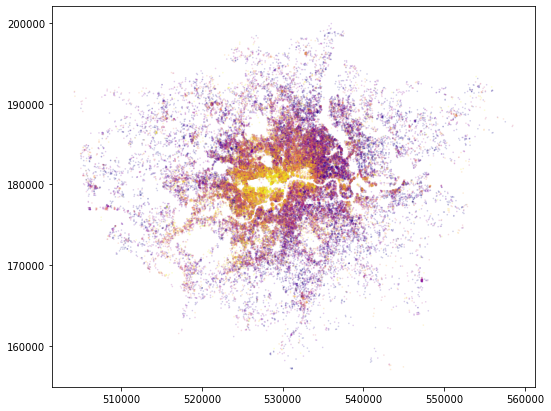

In [32]:
boro_listings.plot(column = 'price', cmap='plasma', scheme='quantiles', k=10, 
              markersize=.5, alpha=0.15, figsize=(10,7));

## Data Exploration

### Aggregate listings by boroughs

#### 1) Price per borough

In [33]:
boro_price_median = boro_listings.groupby('GSS_CODE')['price'].agg('median')
boro_price_median.sort_values(ascending = False).head(n=5)

GSS_CODE
E09000001   150.00
E09000020   150.00
E09000033   140.00
E09000007   100.00
E09000013    95.00
Name: price, dtype: float64

<AxesSubplot:>

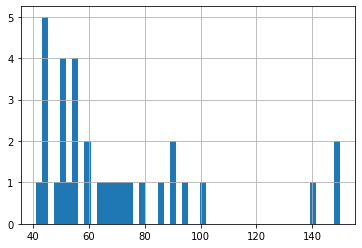

In [34]:
# median price distribution of London boroughs
# The price for one night in Wealthy boroughs are above 140 us dollars 

boro_price_median.hist(bins = 50)

#### 2) Price by Room type

In [35]:
# median room price per borough
boro_room_price = boro_listings.groupby(['GSS_CODE', 'room_type'
                              ])['price'].agg('median').reset_index().dropna(axis = 0)

boro_room_price.head(n=3)

,GSS_CODE,room_type,price
0,E09000001,Entire home/apt,151.00
1,E09000001,Hotel room,154.00
2,E09000001,Private room,65.00


#### 3) Listings with high price

In [36]:
# The median room price ranges between 40 - 160 dollars per night
# So this can be our criteria for filtering unusually expensive listings

boro_listings[(boro_listings.GSS_CODE.isin(boro_price_median[boro_price_median > 140].index)) & 
    (boro_listings.room_type != 'Entire home/apt') 
].sort_values(by='price', ascending=False).head(3)[
    ['price','room_type','property_type','name','description']
]

,price,room_type,property_type,name,description
30875,"4,500.00",Private room,Apartment,"CHELSEA!! Beautiful garden room, four poster bed!",The lovely light and airy four poster bedroom ...
26712,"3,000.00",Private room,Apartment,"London single private room, female","1 minute to bus station. 2 min to M&S. tesco ,..."
79499,"1,000.00",Hotel room,Serviced apartment,Stunning 4BD Duplex Apartment in Earls Court F11,This stunning four bedroom apartment in Kensin...


#### 4) Filter Unlikely too expensive listings
- listings' price over 300 per night

In [37]:
# filtering room types that costs more than 300 dollars per night 
# we are filtering so-called outliers as minmaxscaler is vulnerable to outliers.

to_drop = boro_listings[(boro_listings.price > 300) & (boro_listings.room_type != 'Entire home/apt') ]
print(f"Have found {to_drop.shape[0]:,} rows to drop on the basis of unlikely per night prices.")

Have found 404 rows to drop on the basis of unlikely per night prices.


In [38]:
to_drop.sort_values(by='price', ascending=False)[['price','room_type','name','description']]

,price,room_type,name,description
55371,"9,999.00",Hotel room,Eccleston Square Hotel Signature King Room,"Europe’s most cutting-edge luxury hideaway, Ec..."
55376,"9,999.00",Hotel room,Eccleston Square Hotel City King Room,"Europe’s most cutting-edge luxury hideaway, Ec..."
55377,"9,999.00",Hotel room,Eccleston Square Hotel City Queen,"Europe’s most cutting-edge luxury hideaway, Ec..."
64775,"7,852.00",Private room,Chambre Double maison vegetarienne,Boudhiste / vegetarian house filled with green...
14632,"7,693.00",Private room,Spacious Private Ground Floor Room,"On a quiet tree lined road, this ground floor ..."
...,...,...,...,...
56327,310.00,Hotel room,Moorgate One Bedroom Apartment,Design led living quarters offered by The Moor...
19709,310.00,Private room,Gorgeous bedroom in Clerkenwell,One bedroom and private bathroom in Clerkenwel...
13857,305.00,Private room,Studio close to Central London !!,Very nice and clean double private room just 2...
39624,304.00,Private room,Comfortable two bedroom,Location and surroundings 16 km London City Ai...


<AxesSubplot:>

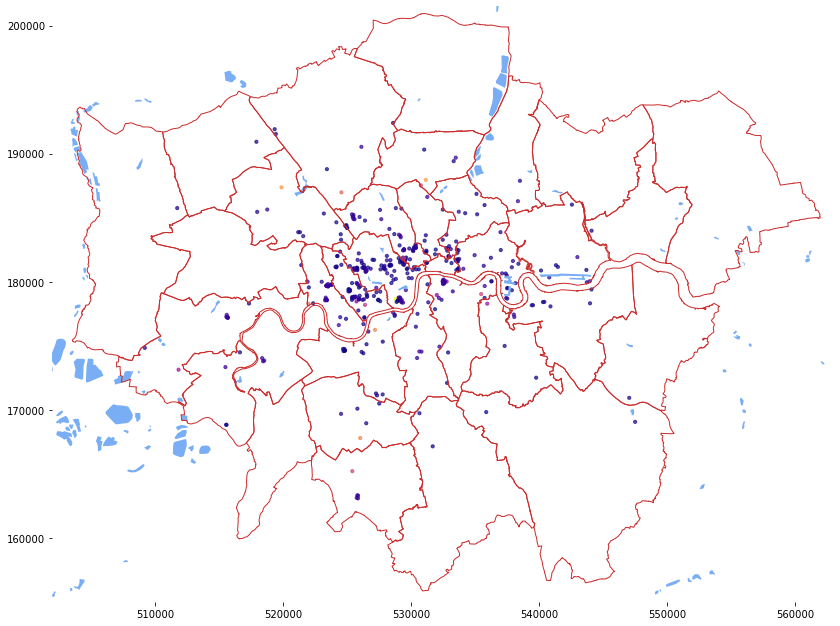

In [39]:
# plot too expensive listings
f,ax = plt_ldn(water, boros)
to_drop.plot(column='price', markersize=10, alpha=0.7, cmap='plasma', ax=ax)

#### 5) Pivot Data - Check discrete room type

In [40]:
# host_id is an unique identifier
# we can check the number of listings that each host possesses
boro_listings.groupby('host_id').host_listings_count.agg(Count = 
                                               'count').reset_index().sort_values(by = 'Count', 
                                                                                  ascending = False)

,host_id,Count
23657,33889201,999
41220,137094377,236
21496,28820321,233
43116,156158778,220
28749,48165024,213
...,...,...
27092,43023101,0
4221,2919276,0
11112,10039712,0
53029,300966707,0


In [41]:
pivot = boro_listings.groupby(['GSS_CODE','room_type']
    
    # listing_url is an unique identifier and 
    # that is why we count number of rooms based on it
        ).host_id.agg(Count='count').reset_index().pivot(
    index='GSS_CODE', columns=['room_type'], values=['Count'])
pivot.head(3)

Count                                    
room_type Entire home/apt Hotel room Private room Shared room
GSS_CODE                                                     
E09000001             388         24           50           2
E09000002             112          5          251           4
E09000003             699         29          916          14

In [42]:
# There are 33 boroughs in London
# and hotel room has
# 3 rows with null values
pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, E09000001 to E09000033
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   (Count, Entire home/apt)  33 non-null     int64
 1   (Count, Hotel room)       33 non-null     int64
 2   (Count, Private room)     33 non-null     int64
 3   (Count, Shared room)      33 non-null     int64
dtypes: int64(4)
memory usage: 1.3+ KB


In [43]:
# fillna() convert the datatype to integer
# There are 3 null values which cause an error
# when converting the data type
# dropna() would drop the whole row
pivot = pivot.fillna(0)

In [44]:
# convert data type
pivot_rev = pivot.astype('int')
pivot_rev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, E09000001 to E09000033
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   (Count, Entire home/apt)  33 non-null     int64
 1   (Count, Hotel room)       33 non-null     int64
 2   (Count, Private room)     33 non-null     int64
 3   (Count, Shared room)      33 non-null     int64
dtypes: int64(4)
memory usage: 1.3+ KB


In [45]:
# We can check the airbnb listings by room_type
# hotel room and shared room are not that significant
# perhaps we can just do pca instead of dropping them?
pivot_rev.sum()

       room_type      
Count  Entire home/apt    47439
       Hotel room          1113
       Private room       35875
       Shared room          628
dtype: int64

In [46]:
# drop insignificant room_type
# if you think we should include them, 
# we can put them and reduce them with PCA
pivot_rev.columns = ['Entire home/apt','Hotel room','Private room','Shared room']
pivot_rev.drop(columns = ['Hotel room', 'Shared room'], inplace = True)

In [47]:
# normalise count of listings
pivot_norm = pd.DataFrame(index=pivot_rev.index)
for c in pivot_rev.columns.to_list():
    # Power Transform
    # count to normalised values
    pivot_norm[c] = pts.fit_transform(pivot_rev[c].to_numpy().reshape(-1,1))

pivot_norm.head()

,Entire home/apt,Private room
GSS_CODE,,
E09000001,-0.47,-2.27
E09000002,-1.48,-1.15
E09000003,-0.00,0.12
E09000004,-1.68,-1.44
E09000005,0.40,0.55


In [48]:
boros.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

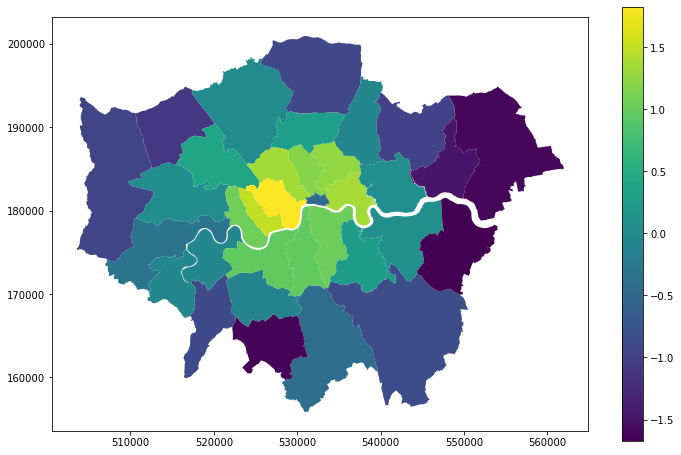

In [49]:
# left join - normalised airbnb data (entire home and private room)+ london borough shp
pnm = pd.merge(boros.set_index('GSS_CODE'), pivot_norm, left_index = True, right_index = True)
pnm.plot(column='Entire home/apt', cmap='viridis', edgecolor='none', legend=True, figsize=(12,8));

In [50]:
# We only have two columns in our pivot_norm
# And 93% of these can be explained by pca component 1
# but is it worth reducing 2 dimensions to 1D?
pcomp = PCA(n_components= 2, random_state=42)
rd    = pcomp.fit_transform(pivot_norm)
print(f"The explained variance of each component is: {', '.join([f'{x*100:.2f}%' for x in pcomp.explained_variance_ratio_])}")
explained_variance = pcomp.explained_variance_ratio_

The explained variance of each component is: 94.16%, 5.84%


In [51]:
rd

array([[-1.94052727e+00,  1.26886890e+00],
       [-1.86081393e+00, -2.32835228e-01],
       [ 7.98051029e-02, -8.49320912e-02],
       [-2.20096474e+00, -1.70399064e-01],
       [ 6.74521500e-01, -1.10361892e-01],
       [-1.13902692e+00, -7.07341101e-02],
       [ 1.70441641e+00,  1.92167534e-01],
       [-4.73387670e-01, -1.46741151e-01],
       [ 1.56732382e-01, -1.19125050e-01],
       [-1.14689250e+00, -1.41081438e-01],
       [ 8.41757707e-02,  1.09228495e-02],
       [ 1.99831288e+00, -2.30165309e-01],
       [ 1.22974856e+00,  2.67793984e-01],
       [ 4.86330342e-01, -1.06665293e-01],
       [-1.48117544e+00, -9.31841101e-02],
       [-2.21474488e+00, -6.84425712e-02],
       [-1.13631752e+00, -2.24828180e-01],
       [-5.44722909e-01,  7.61558331e-02],
       [ 1.54711507e+00,  1.32640079e-01],
       [ 1.19432669e+00,  9.36870618e-01],
       [-1.29562791e+00,  3.26813386e-02],
       [ 1.62464360e+00, -2.44994325e-01],
       [ 5.53988179e-01, -1.96212757e-01],
       [-1.

In [52]:
# we are only choosing first component
# I just kept these 1 col

airbnb_pca = pd.DataFrame(
    # rescaling data with minmax scaler
                {'2019_Airbnb Component 1': mms.fit_transform(rd[:,0].reshape(-1,1)).reshape(1,-1)[0]},
                index=pivot.index)



# In case, you want to keep two cols
#airbnb_pca = pd.DataFrame(
    # rescaling data with minmax scaler
 #               {'2019_Airbnb Component 1': mms.fit_transform(rd[:,0].reshape(-1,1)).reshape(1,-1)[0], 
  #              '2019_Airbnb Component 2': mms.fit_transform(rd[:,1].reshape(-1,1)).reshape(1,-1)[0]},
   #             index=pivot.index)

airbnb_pca.head()

,2019_Airbnb Component 1
GSS_CODE,
E09000001,-0.88
E09000002,-0.85
E09000003,-0.03
E09000004,-0.99
E09000005,0.23


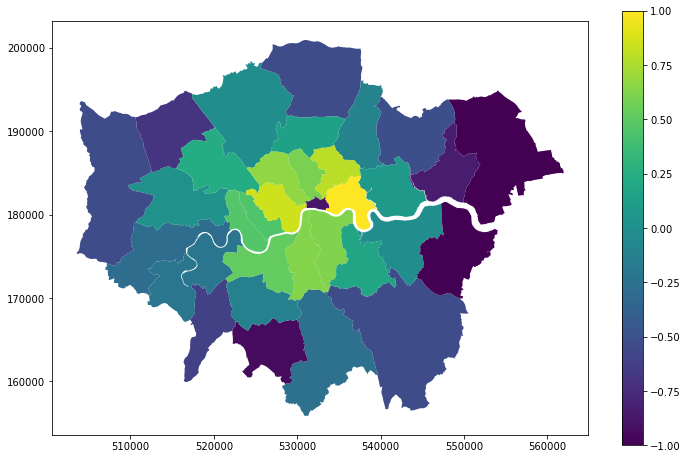

In [53]:
# seems like there is a problem with shape file
pcanm = pd.merge(boros.set_index('GSS_CODE'), airbnb_pca, left_index=True, right_index=True)
pcanm.plot(column='2019_Airbnb Component 1', cmap='viridis', edgecolor='none', legend=True, figsize=(12,8));

## Data Merge

In [54]:
# Result Set from merge
# set 'gss_code' as an index to merge data
ldn_gss_idx = boro_listings.set_index('GSS_CODE')

rs = pd.merge(ldn_gss_idx, airbnb_pca, left_index=True, right_index = True)
len(rs)

85055

#### Write to the previous DataFrame

Originally, the dataframe 'cluster' should be data with standardised census tract

As we don't have the data yet, I subsetted the merged airbnb data (pca + airbnb data)

The data that will be used for clustering should be in numeric types

In [55]:
# Add median, mean price data and the PCA-reduced Airbnb data
# we have to create a data frame just for clustering
cluster = rs.reset_index().iloc[:, [0, -1]].copy().set_index('GSS_CODE')


# Append median price from cleaned listings grouped by GSS_CODE
s1 = rs.groupby(by='GSS_CODE').price.agg('median')
# rescale median price by using minmaxscaler
cluster['2019_median_price'] = pd.Series(np.squeeze(mms.fit_transform(s1.values.reshape(-1,1))), index=s1.index)

# Append mean price from cleaned listings grouped by GSS_CODE
s2 = rs.groupby(by='GSS_CODE').price.agg('mean')
# rescale mean price by using minmaxscaler
cluster['2019_mean_price'] = pd.Series(np.squeeze(mms.fit_transform(s2.values.reshape(-1,1))), index=s2.index)

cluster

# cldf is a merged numeric data of census tract and airbnb data
#s2 = cleaned.groupby(by='MSOA11CD').price.agg('mean')
#cldf['mean_price'] = pd.Series(np.squeeze(mms.fit_transform(s2.values.reshape(-1,1))), index=s2.index)

#cldf.drop(columns=['Subregion','Borough'], inplace=True)

#cldf.head()

,2019_Airbnb Component 1,2019_median_price,2019_mean_price
GSS_CODE,,,
E09000001,-0.88,1.00,0.66
E09000001,-0.88,1.00,0.66
E09000001,-0.88,1.00,0.66
E09000001,-0.88,1.00,0.66
E09000001,-0.88,1.00,0.66
...,...,...,...
E09000033,0.85,0.82,0.99
E09000033,0.85,0.82,0.99
E09000033,0.85,0.82,0.99


## 1) K-Means Clustering

The code below can be used when we have a specific clustering number in mind.

In [56]:
# fit numeric values - airbnb PCA, mean and median price
# we are fitting the data we created above for clustering 

c_nm   = 'KMeans' # Clustering name
k_pref = 5 # Number of clusters

kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(cluster) # The process

In [57]:
cluster

,2019_Airbnb Component 1,2019_median_price,2019_mean_price
GSS_CODE,,,
E09000001,-0.88,1.00,0.66
E09000001,-0.88,1.00,0.66
E09000001,-0.88,1.00,0.66
E09000001,-0.88,1.00,0.66
E09000001,-0.88,1.00,0.66
...,...,...,...
E09000033,0.85,0.82,0.99
E09000033,0.85,0.82,0.99
E09000033,0.85,0.82,0.99


In [58]:
# Assign clustering number to each listing
# Warning!
# We are creating Kmeans column on the original datasets
# The dataset we created for clustering is only used for index nothing more.
rs[c_nm] = pd.Series(kmeans.labels_, index= cluster.index)

In [59]:
rs['2019_median_price'] = pd.Series(cluster['2019_median_price'], cluster.index)
rs['2019_mean_price'] = pd.Series(cluster['2019_mean_price'], cluster.index)

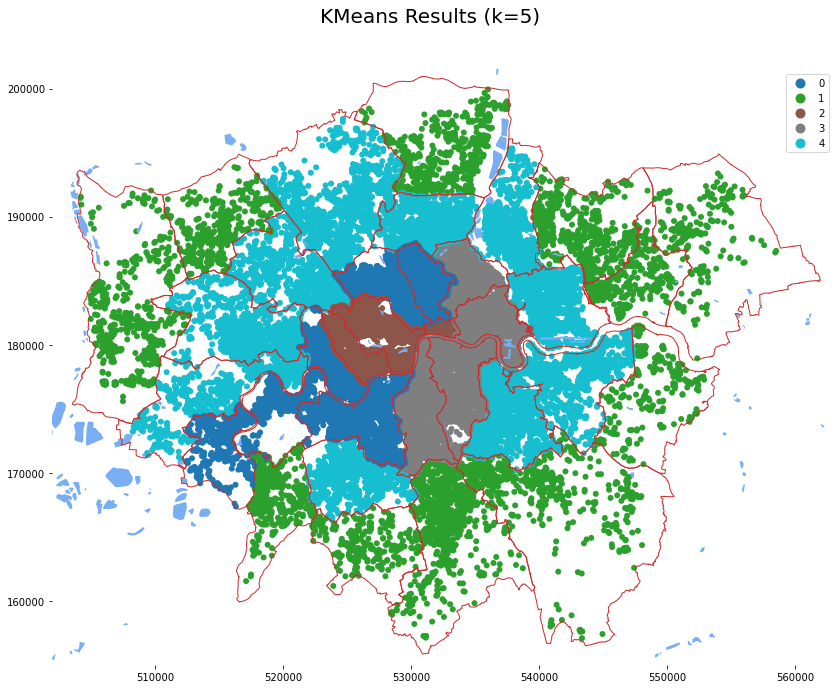

In [60]:
# plot
fig, ax = plt_ldn(water, boros)
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True);

## Moran's I

Steps we've taken until now:
- We have eliminated two insignificant room_types (hotel, shared room) based on their numbers.
- We have normalised our airbnb data using powertransformation.
- We have reduced our airbnb dimensions from 2 to 1. The representiveness of first PCA component is 94 %.
- We have rescaled average/median price by using minmaxcaler.

Steps to take:
- We have to calculate spatial lag of our variable of interest. As we are very much keen on the number of airbnb listings, we have to create a spatial lage of pca-version of airbnb listing count.

In [61]:
# Create a new DataFrame that only has the columns we are interested in.
# But keep in mind, you should have geometry column for Local Moran's I test

df = rs.copy()
df.drop(columns = ['id',
 'name',
 'description',
 'host_id',
 'host_location',
 'host_listings_count',
 'host_total_listings_count',
 'property_type',
 'room_type',
 'minimum_nights',
 'maximum_nights',
 'borough',
 'price',
 'NAME', 'KMeans'], inplace = True)

df = df[['2019_Airbnb Component 1', '2019_median_price', '2019_mean_price', 'geometry']]
df.head(n=3)

,2019_Airbnb Component 1,2019_median_price,2019_mean_price,geometry
GSS_CODE,,,,
E09000001,-0.88,1.00,0.66,POINT (533569.810 180953.752)
E09000001,-0.88,1.00,0.66,POINT (532283.423 181370.784)
E09000001,-0.88,1.00,0.66,POINT (533742.318 181074.020)


In [62]:
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pysal.viz import mapclassify
import numpy as np
import esda
from pysal.lib import weights
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
from esda.moran import Moran_Local
from giddy.directional import Rose
from pysal.lib import weights
import libpysal
import splot
from splot.giddy import dynamic_lisa_composite

In [63]:
df

,2019_Airbnb Component 1,2019_median_price,2019_mean_price,geometry
GSS_CODE,,,,
E09000001,-0.88,1.00,0.66,POINT (533569.810 180953.752)
E09000001,-0.88,1.00,0.66,POINT (532283.423 181370.784)
E09000001,-0.88,1.00,0.66,POINT (533742.318 181074.020)
E09000001,-0.88,1.00,0.66,POINT (533715.951 181073.326)
E09000001,-0.88,1.00,0.66,POINT (533220.531 180927.892)
...,...,...,...,...
E09000033,0.85,0.82,0.99,POINT (527290.552 181192.077)
E09000033,0.85,0.82,0.99,POINT (526978.336 182406.052)
E09000033,0.85,0.82,0.99,POINT (527139.926 181745.788)


In [64]:
# Generate W from the GeoDataFrame
# I believe Queen's case makes more sense as we can link many neighbourhoods as many as possible
# so we can capture more local trend?
w = weights.Queen.from_dataframe(df)

# Row-standardization
w.transform = "R"

In [65]:
# Spatial lag of our airbnb listings
df["w_2019_Airbnb Component 1"] = weights.spatial_lag.lag_spatial(
    w, df["2019_Airbnb Component 1"]
)
df.head(n=3)

,2019_Airbnb Component 1,2019_median_price,2019_mean_price,geometry,w_2019_Airbnb Component 1
GSS_CODE,,,,,
E09000001,-0.88,1.00,0.66,POINT (533569.810 180953.752),-0.88
E09000001,-0.88,1.00,0.66,POINT (532283.423 181370.784),-0.88
E09000001,-0.88,1.00,0.66,POINT (533742.318 181074.020),-0.88


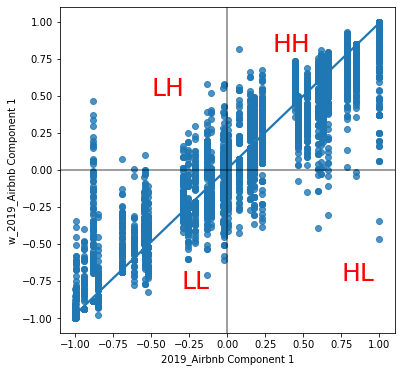

In [66]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(
    x= "2019_Airbnb Component 1", y="w_2019_Airbnb Component 1", data=df, ci=None
);

# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(0.3, 0.8, "HH", fontsize=25, c="r")
plt.text(0.75, -0.75, "HL", fontsize=25, c="r")
plt.text(-0.5, 0.5, "LH", fontsize=25, c="r")
plt.text(-0.3, -0.8, "LL", fontsize=25, c="r")
# Display
plt.show()

Using standardized values, we can immediately divide each variable 

The airbnb pca component, and its spatial lag in two groups: 

those with above-average airbnb listings, which have positive standardized values;


those with below-average airbnb listings, which have negative standardized values;

In [67]:
# Local Moran's I
lisa_19 = esda.Moran_Local(df['2019_Airbnb Component 1'], w, seed = 42)

We need to pass the variable of interest — Airbnb PCA Component 1 in this context — 

and the spatial weights that describe the neighborhood relations between the different areas that make up the dataset. 

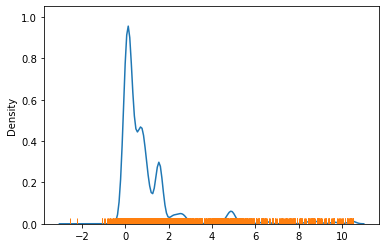

In [68]:
# Draw KDE line
ax = sns.kdeplot(lisa_19.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(lisa_19.Is, ax=ax);

The firgure shows a positively skewed distribution of local Moran'I statistics.

This indicates that most of Moran's I statistics values are positive.

Hence, we need to bear in mind that the high positive values arise from value similarity in space.

This can be due to either high values being next to high values or low values next to low values.

In other words, **Positive Autocorrelation**

But local Moran's I cannot distinguish which one it is between two.

### Choropleth plots of local Moran's I

In [69]:
# package
from splot import esda as esdaplot

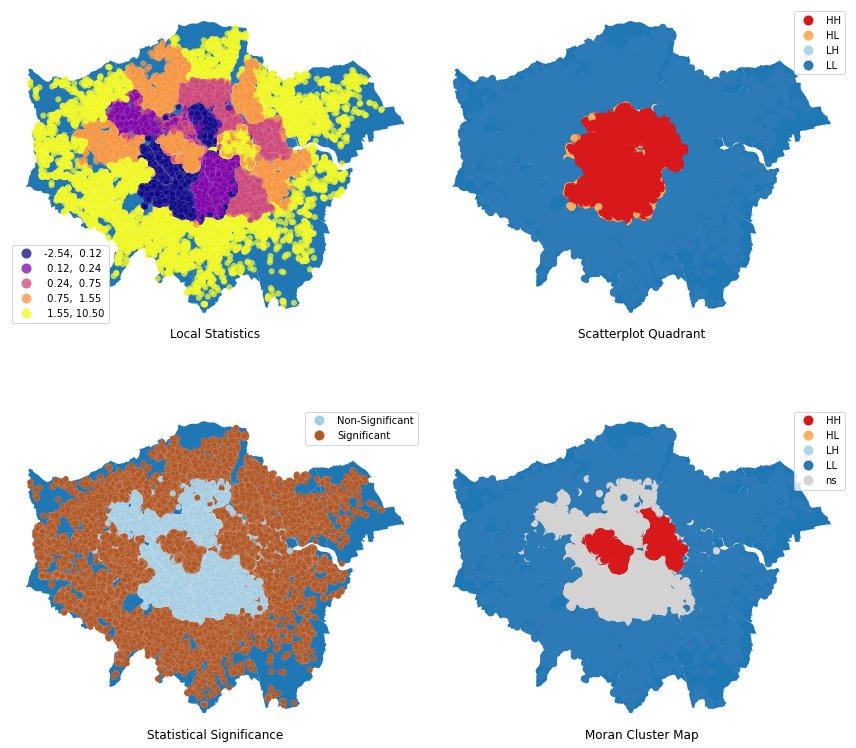

In [70]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# London borough map
boros.plot(ax = ax)
# Assign new column with local statistics on-the-fly
df.assign(
    Is=lisa_19.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)


# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# London borough map
boros.plot(ax = ax)
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa_19, df, p=1, ax=ax)


# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
# London borough map
boros.plot(ax = ax)
# Find out significant observations
labels = pd.Series(
    1 * (lisa_19.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=df.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
df.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)




# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# London borough map
boros.plot(ax = ax)
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa_19, df, p=0.05, ax=ax)



# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=-0.05,
    )
    

# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()

### Insight

The yellow and purple in the map on the upper left side, largest magnitudes which can be either high or low values.

The map on the upper right corner shows the location of the LISA statistic in the quadrant of the Moran Scatter plot.

In [71]:
# count quadrant
# 1 means High-High quadrant
# 2 means Low-High quadrant
# 3 means Low-Low quadrant
# 4 means High-Low quadrant
counts = pd.value_counts(lisa_19.q)
counts

1    59041
3    25553
4      391
2       70
dtype: int64

### Insight
- HH (1) and LL (3) values are predominant.
- First two maps simply mapped the raw LISA value alongside the quadrant in which the local statistic resides. However, it didn't take into account statistical significance.
- The cluster map includes significance information alongside the quadrant and local statistic. Together, this map extracts significant observations -those that are highly unlikely to have come from pure chance- and plots them with a specific color depending on their quadrant category. 

In [72]:
# Statistically significant lisa statistics
(lisa_19.p_sim < 0.05).sum() * 100 / len(lisa_19.p_sim)

49.92299100581976

Nearly half of polygons that have degrees of local spatial association strong enough to reject the idea of pure chance.

Kensington and Chelsea and East London of Inner London areas indicate a high airbnb density.

While we can see clearly a low density of airbnb in Outer London.


In [73]:
# Assign pseudo P-values to `db`
df["p-sim"] = lisa_19.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa_19.p_sim < 0.05)
# Assign significance flag to `db`
df["sig"] = sig

In [74]:
# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots = lisa_19.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}

# Create column in `db` with labels for each polygon
df["labels"] = pd.Series(
    # First initialise a Series using values and `db` index
    spots,
    index=df.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)

# Print first few rows
df["labels"].head()

GSS_CODE
E09000001    LL
E09000001    LL
E09000001    LL
E09000001    LL
E09000001    LL
Name: labels, dtype: object

In [90]:
# print out the boroughs with high densities of airbnb 
gent_airbnb = df['labels'].copy().reset_index()
gent_airbnb.head(n=3)

,GSS_CODE,labels
0,E09000001,LL
1,E09000001,LL
2,E09000001,LL


In [91]:
# new DataFrame to merge
boroname = rs.copy().reset_index()[['borough', 'GSS_CODE']]
boroname.head(n=3)

,borough,GSS_CODE
0,City of London,E09000001
1,City of London,E09000001
2,City of London,E09000001


In [92]:
final_2019 = gent_airbnb.join(boroname, lsuffix="_left", rsuffix="_right")
final_2019 = final_2019.rename(columns = {'GSS_CODE_left': 'GSS_CODE'})
final_2019.head(n=1)

,GSS_CODE,labels,borough,GSS_CODE_right
0,E09000001,LL,City of London,E09000001


In [93]:
final_2019.drop(columns = 'GSS_CODE_right', inplace = True)
final_2019.head(n=1)

,GSS_CODE,labels,borough
0,E09000001,LL,City of London


In [96]:
final_2019 = final_2019[['GSS_CODE', 'borough', 'labels']]

In [97]:
# Filter HH and HL as they could be related to gentrification?
probable_gent = final_2019.loc[(final_2019['labels'] == 'HH') | (final_2019['labels'] == 'HL') |
                              (final_2019['labels'] == 'LH')]

In [98]:
probable_gent.borough.value_counts()

Westminster               9455
Tower Hamlets             8190
Hackney                   6082
Camden                      83
Southwark                   31
Islington                   24
Lambeth                      8
Hammersmith and Fulham       6
Wandsworth                   5
Kensington and Chelsea       4
Newham                       0
Richmond upon Thames         0
Sutton                       0
Merton                       0
Lewisham                     0
Waltham Forest               0
Kingston upon Thames         0
Redbridge                    0
Barking and Dagenham         0
Hounslow                     0
Barnet                       0
Havering                     0
Harrow                       0
Haringey                     0
Greenwich                    0
Enfield                      0
Ealing                       0
Croydon                      0
City of London               0
Bromley                      0
Brent                        0
Bexley                       0
Hillingd

### Interpretation of Local Moran's I

Gentrification might be related to areas labelled as HL or LH  
 
- HH are places where airbnbs are already densely populated or gentrified

- LH means low values are surrounded by high values so we could think these are the areas under gentrification?

- HL means high values are surrounded by low values so airbnb could expand to its neighbouring areas?